# Analyzing Tweets with spaCy

In [1]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set()
import spacy
from spacy import displacy
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

## Main Functions

In [2]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt 

In [3]:
def pre_clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove hashtags (#xxx)
    lst = np.vectorize(remove_pattern)(lst, "#[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z]", " ")
    return lst

In [4]:
punctuations = string.punctuation

In [5]:
def spacy_cleanup_text(docs):
    texts = []
    for doc in docs:
        doc = nlp(doc)
        # tokens = [tok for tok in doc if tok.pos_ != 'PROPN'] # ====== VERiFY ===========
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [6]:
filepath = 'port_stopwords.txt'
port_stopwords = []
with open(filepath) as fp:
    line = fp.readline()
    while line:
        port_stopwords.append(line.strip())
        line = fp.readline()
stopwords = set(port_stopwords)

---

## Importing datasets with Pandas

In [7]:
jb_tws = pd.read_csv('jairbolsonaro_tweets.csv')
jb_tws.shape

(3185, 4)

In [8]:
jb_tws.head()

,created_at,retweets,favorites,text
0,2019-03-31 18:24:50,2985,17307,Reconhecendo os vínculos históricos de Jerusal...
1,2019-03-31 12:19:57,6288,34952,Chegamos há pouco em Israel. Fomos recepcionad...
2,2019-03-31 10:22:14,4035,30343,Ao renovar as concessões de trechos rodoviário...
3,2019-03-31 10:19:02,6327,41684,Após revelação do @MInfraestrutura de pedidos ...
4,2019-03-30 20:25:30,5619,26156,- Ministro da Infraestrutura @tarcisiogdf (cap...


In [9]:
# Verifing a single tweet text
jb_tws.text[1]

'Chegamos há pouco em Israel. Fomos recepcionados pelo Primeiro-Ministro @netanyahu e pudemos proferir palavras à esta nação amiga e o intuito de nossa viagem. Shalom! 🇧🇷🤝🇮🇱 https://t.co/TyWd5pKs0S'

### Cleaning tweets 

In [13]:
nlp = spacy.load("pt_core_news_sm")

In [11]:
jb_tws['clean_text'] = pre_clean_tweets(jb_tws['text'])

In [12]:
jb_tws['clean_text'] = spacy_cleanup_text(jb_tws['clean_text'])

In [13]:
jb_tws.head()

,created_at,retweets,favorites,text,clean_text
0,2019-03-31 18:24:50,2985,17307,Reconhecendo os vínculos históricos de Jerusal...,reconhecendo vínculo histórico jerusalém ident...
1,2019-03-31 12:19:57,6288,34952,Chegamos há pouco em Israel. Fomos recepcionad...,chegamos haver israel recepcionados pelar prim...
2,2019-03-31 10:22:14,4035,30343,Ao renovar as concessões de trechos rodoviário...,renovar concessão trecho rodoviário revisar co...
3,2019-03-31 10:19:02,6327,41684,Após revelação do @MInfraestrutura de pedidos ...,revelação pedir pronto 8.000 radar eletrônicos...
4,2019-03-30 20:25:30,5619,26156,- Ministro da Infraestrutura @tarcisiogdf (cap...,ministro infraestrutura capitão exército espec...


In [14]:
jb_tws.clean_text[1]

'chegamos haver israel recepcionados pelar primeiro-ministro proferir palavra nação amigo intuito shalom 🇧 🇷 🤝 🇮 🇱'

---

In [15]:
txt = jb_tws.clean_text[1]

In [16]:
doc = nlp(txt)

In [17]:
for token in doc: 
    print(f'{token.text:{20}} {token.pos_:{10}} {token.dep_:{12}} {spacy.explain(token.tag_)}')

chegamos             AUX        aux          None
haver                VERB       ROOT         None
israel               NOUN       obj          None
recepcionados        VERB       acl          None
pelar                VERB       acl          None
primeiro-ministro    NOUN       obj          None
proferir             VERB       acl          None
palavra              NOUN       obj          None
nação                NOUN       obj          None
amigo                ADJ        amod         None
intuito              ADJ        nmod:npmod   None
shalom               ADJ        advmod       None
🇧                    ADJ        advmod       None
🇷                    PROPN      obj          proper noun
🤝                    PROPN      nummod       proper noun
🇮                    X          ROOT         other
🇱                    ADJ        appos        None


In [18]:
tokens = [token for token in doc]

In [19]:
[token.lemma_ for token in doc if token.pos_ == 'VERB']

['haver', 'recepcionados', 'pelar', 'proferir']

In [20]:
doc.ents

(🇷, 🇮)

In [21]:
[(entity, entity.label_) for entity in doc.ents]

[(🇷, 'MISC'), (🇮, 'MISC')]

In [22]:
for token in doc:
    print("{0}\t{1}\t{2}\t{3}\t{4}\t{5}\t{6}\t{7}".format(
        token.text, token.idx, token.lemma_, token.is_punct, token.is_space,
        token.shape_, token.pos_, token.tag_))

chegamos	0	chegar	False	False	xxxx	AUX	<aux>|V|PR|1P|IND|@FS-STA
haver	9	haver	False	False	xxxx	VERB	<mv>|V|INF|@ICL-AUX<
israel	15	israel	False	False	xxxx	NOUN	<np-idf>|N|F|S|@<ACC
recepcionados	22	recepcionados	False	False	xxxx	VERB	<mv>|V|PCP|M|P|@ICL-N<
pelar	36	pelar	False	False	xxxx	VERB	<mv>|V|INF|@ICL-<ACC
primeiro-ministro	42	primeiro-ministro	False	False	xxxx-xxxx	NOUN	<np-idf>|N|M|S|@N<
proferir	60	proferir	False	False	xxxx	VERB	<mv>|V|INF|@ICL-<ACC
palavra	69	palavra	False	False	xxxx	NOUN	<np-idf>|N|F|S|@<ACC
nação	77	nação	False	False	xxxx	NOUN	<np-idf>|N|F|S|@<ACC
amigo	83	amigar	False	False	xxxx	ADJ	ADJ|M|S|@N<
intuito	89	intuito	False	False	xxxx	ADJ	ADJ|M|S|@N<
shalom	97	shalom	False	False	xxxx	ADJ	ADJ|M|S|@N<
🇧	104	🇧	False	False	🇧	ADJ	ADJ|M|S|@N<
🇷	106	🇷	False	False	🇷	PROPN	PROPN
🤝	108	🤝	False	False	🤝	PROPN	PROPN
🇮	110	🇮	False	False	🇮	X	X
🇱	112	🇱	False	False	🇱	ADJ	ADJ|M|S|@N<


In [23]:
for sent in doc.sents:
    print(sent)

chegamos haver israel recepcionados pelar primeiro-ministro proferir palavra nação amigo intuito shalom 🇧 🇷
🤝 🇮 🇱


In [24]:
displacy.render(doc, style='ent', jupyter=True)

In [25]:
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

## Emotion and Sentiment Analysis
Using py-lex, a python library for parsing and applying emotion, socio-psycho, and sentiment datasets to your own text corpora.py-lex uses as dataset, NRC Emolex. <br><br>
NRC Word-Emotion Association Lexicon (aka EmoLex): The NRC Emotion Lexicon is a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). The annotations were manually done by crowdsourcing. The dataset is in english but  is also available in other languages as portuguese, by appying Google Translator on it.<br>
Paper: Saif et al, 2013: "Crowdsourcing a Word–Emotion Association Lexicon": https://arxiv.org/pdf/1308.6297.pdf<br><br>
NRC EmoLex: 
http://sentiment.nrc.ca/lexicons-for-research/ <br>
py-lex: https://github.com/dropofwill/py-lex
<br><br>
Thanks to: Alex Ingberg for code ideas: https://towardsdatascience.com/data-data-1fedfac91c79

### Creating a Portuguese EmoLexicon
https://github.com/alexing/datadata/blob/master/constructing_lexicon.ipynb

In [26]:
xlsx = pd.read_excel("./NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92-InManyLanguages.xlsx")
xlsx = xlsx[['English Word', 'Portuguese Translation (Google Translate)', 'Anger', 
             'Anticipation', 'Disgust', 'Fear','Joy', 'Negative', 'Positive', 
             'Sadness', 'Surprise', 'Trust']]

In [27]:
xlsx.sample(5)

,English Word,Portuguese Translation (Google Translate),Anger,Anticipation,Disgust,Fear,Joy,Negative,Positive,Sadness,Surprise,Trust
8341,negligence,negligência,0,0,0,0,0,1,0,0,0,0
12201,submission,apresentação,0,0,0,0,0,0,0,0,0,0
13476,unthinkable,impensável,1,0,1,1,0,1,0,0,0,0
4895,filmy,membranoso,0,0,0,0,0,0,0,0,0,0
13470,unsustainable,insustentável,0,0,0,0,0,1,0,0,0,0


In [28]:
xlsx.columns = ['english', 'portuguese', 'anger', 
             'anticipation', 'disgust', 'fear','joy', 'negative', 'positive', 
             'sadness', 'surprise', 'trust']
columns_to_iterate = ['anger', 
             'anticipation', 'disgust', 'fear','joy', 'negative', 'positive', 
             'sadness', 'surprise', 'trust']

In [29]:
with open('./NRC-Sentiment-Emotion-Lexicons/lexicon_portuguse.txt', 'a') as f:
    for index, a_word in xlsx.iterrows():
        for a_column in columns_to_iterate:
            line = "%s\t%s\t%d\n" % (a_word['portuguese'], a_column, a_word[a_column])
            f.write(line)

### Applying Portuguese EmoLex on tweets

In [7]:
from py_lex import Liwc, EmoLex

In [8]:
lexicon = EmoLex('./NRC-Sentiment-Emotion-Lexicons/lexicon_portuguse.txt')

In [32]:
lexicon.keys()

{'anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'negative',
 'positive',
 'sadness',
 'surprise',
 'trust'}

In [33]:
txt = jb_tws.text[2]
doc = nlp(txt)
doc

Ao renovar as concessões de trechos rodoviários, revisaremos todos os contratos de radares verificando a real necessidade de sua existência para que não sobrem dúvidas do enriquecimento de poucos em detrimento da paz do motorista.

In [34]:
tokens = [token for token in doc]

In [35]:
# Creating a list of tokens as strings
list_of_strings  = [i.text for i in tokens]

In [36]:
summary = lexicon.summarize_doc(list_of_strings)
summary

{'anger': 0.0,
 'joy': 0.0,
 'surprise': 0.0,
 'fear': 0.0,
 'sadness': 0.02857142857142857,
 'trust': 0.02857142857142857,
 'positive': 0.08571428571428572,
 'disgust': 0.0,
 'anticipation': 0.02857142857142857,
 'negative': 0.02857142857142857}

In [37]:
annotation = lexicon.annotate_doc(list_of_strings)
annotation

[set(),
 {'anticipation', 'positive'},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {'positive', 'trust'},
 {'sadness'},
 set(),
 set(),
 {'positive'},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {'negative'},
 set(),
 set(),
 set(),
 set(),
 set()]

In [9]:
def get_sentiments(txt):
    doc = nlp(txt)
    tokens = [token for token in doc]
    list_of_strings  = [i.text for i in tokens]
    summary = lexicon.summarize_doc(list_of_strings)
    return summary

In [10]:
def get_list_sentiments(txt):
    doc = nlp(txt)
    tokens = [token for token in doc]
    list_of_strings  = [i.text for i in tokens]
    annotation = lexicon.annotate_doc(list_of_strings)
    return annotation

In [11]:
def show_annotation(txt):
    lst = txt.split()
    sent = get_list_sentiments(txt)
    for i in range (0, len(lst)):
        print (lst[i], end = ' ')
        if sent[i] != set():
            print (" ==> ", sent[i])
        else:
            print (" ")

In [41]:
txt = jb_tws.text[2]
get_sentiments(txt)

{'anger': 0.0,
 'joy': 0.0,
 'surprise': 0.0,
 'fear': 0.0,
 'sadness': 0.02857142857142857,
 'trust': 0.02857142857142857,
 'positive': 0.08571428571428572,
 'disgust': 0.0,
 'anticipation': 0.02857142857142857,
 'negative': 0.02857142857142857}

In [42]:
txt = jb_tws.clean_text[2]

In [43]:
txt

'renovar concessão trecho rodoviário revisar contrato radar verificar real necessidade suar existência parir sobrar enriquecimento detrimento paz motorista'

In [44]:
get_list_sentiments(txt)

[{'anticipation', 'positive'},
 set(),
 set(),
 set(),
 set(),
 set(),
 {'trust'},
 set(),
 {'positive', 'trust'},
 {'sadness'},
 set(),
 {'positive'},
 set(),
 set(),
 set(),
 {'negative'},
 set(),
 set()]

In [45]:
show_annotation(txt)

renovar  ==>  {'positive', 'anticipation'}
concessão  
trecho  
rodoviário  
revisar  
contrato  
radar  ==>  {'trust'}
verificar  
real  ==>  {'positive', 'trust'}
necessidade  ==>  {'sadness'}
suar  
existência  ==>  {'positive'}
parir  
sobrar  
enriquecimento  
detrimento  ==>  {'negative'}
paz  
motorista  


### Creating columns for sentiments on tweet dataset

In [46]:
jb_tws['anger'] = 0.0
jb_tws['anticipation'] = 0.0
jb_tws['disgust'] = 0.0
jb_tws['fear'] = 0.0
jb_tws['joy'] = 0.0
jb_tws['negative'] = 0.0
jb_tws['positive'] = 0.0
jb_tws['sadness'] = 0.0
jb_tws['surprise'] = 0.0
jb_tws['trust'] = 0.0

In [47]:
jb_tws.head(2)

,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,2019-03-31 18:24:50,2985,17307,Reconhecendo os vínculos históricos de Jerusal...,reconhecendo vínculo histórico jerusalém ident...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-03-31 12:19:57,6288,34952,Chegamos há pouco em Israel. Fomos recepcionad...,chegamos haver israel recepcionados pelar prim...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
for index, _ in jb_tws.iterrows():
    txt = jb_tws.clean_text[index]    
    summary =  get_sentiments(txt)
    for key in summary.keys():
        jb_tws.at[index, key] = summary[key]

In [49]:
jb_tws.head(2)

,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,2019-03-31 18:24:50,2985,17307,Reconhecendo os vínculos históricos de Jerusal...,reconhecendo vínculo histórico jerusalém ident...,0.0,0.0,0.045455,0.0,0.0,0.0,0.181818,0.0,0.0,0.045455
1,2019-03-31 12:19:57,6288,34952,Chegamos há pouco em Israel. Fomos recepcionad...,chegamos haver israel recepcionados pelar prim...,0.0,0.0,0.000000,0.0,0.0,0.0,0.083333,0.0,0.0,0.166667


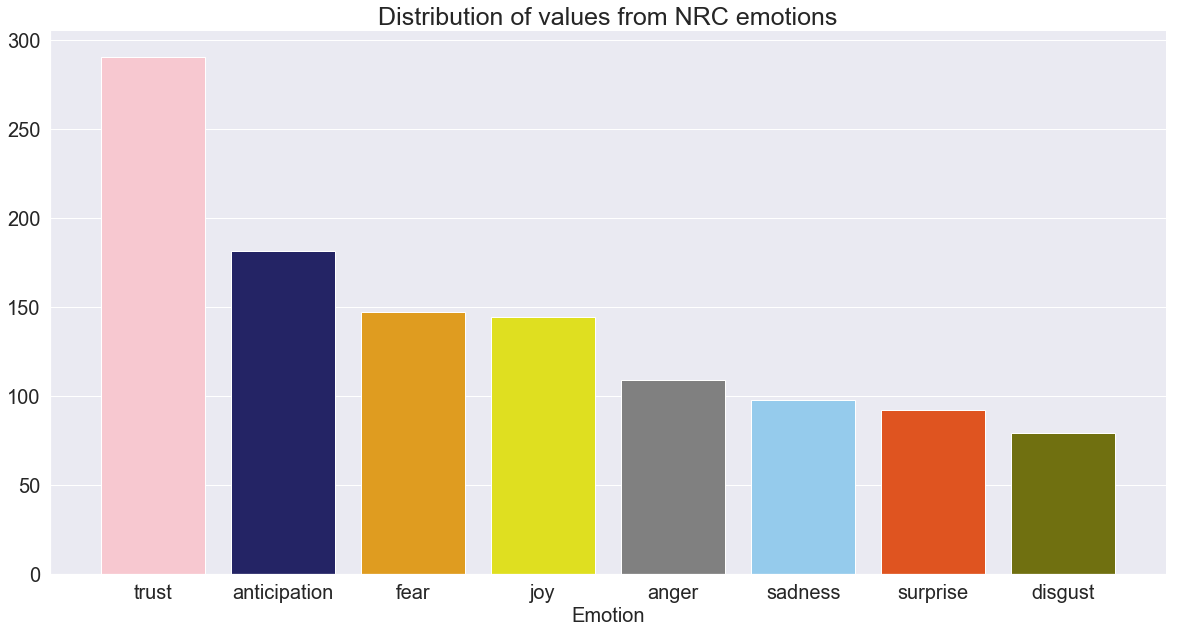

In [50]:
total_sentiments = pd.DataFrame(jb_tws.sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']].sort_values(ascending=False))
colors = ['pink', 'midnightblue', 'orange', 'yellow', 'grey', 'lightskyblue', 'orangered',  'olive']
total_sentiments.columns = ['value']

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=total_sentiments.index, y='value', data=total_sentiments, palette=sns.color_palette(colors))
plt.ylabel("")
plt.xlabel('Emotion', fontsize=20)
plt.title('Distribution of values from NRC emotions', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
sns.despine()
plt.plot();

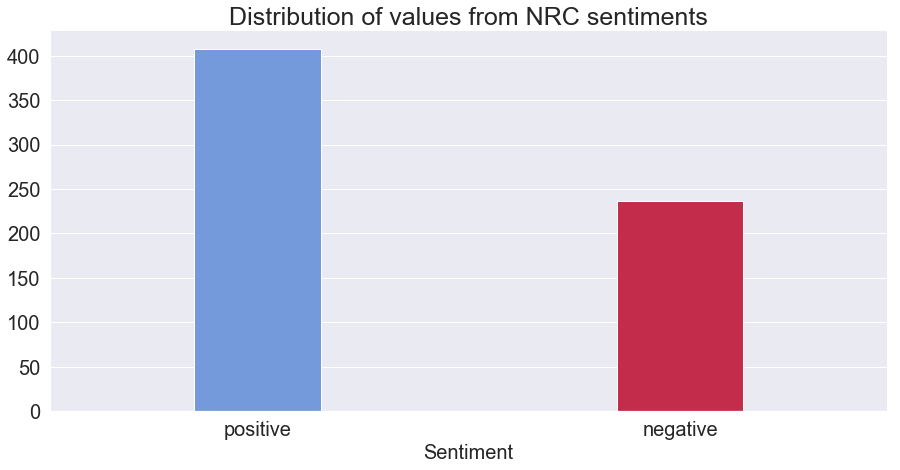

In [51]:
total_sentiment = pd.DataFrame(jb_tws.sum()[['positive', 'negative']])
total_sentiment.columns = ['value']

fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(x=total_sentiment.index, y='value', data=total_sentiment, palette=sns.color_palette(['cornflowerblue', 'crimson']))
plt.ylabel("")
plt.xlabel('Sentiment', fontsize=20)
plt.title('Distribution of values from NRC sentiments', fontsize=25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - .3

    # we change the bar width
    patch.set_width(.3)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)
sns.despine()
plt.plot();

In [52]:
columns = ['word','fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust', 'positive', 'negative']

In [53]:
word_appearances_by_sentiment = pd.DataFrame(columns=columns)
for index, _ in jb_tws.iterrows():
    txt = jb_tws.clean_text[index]   
    doc = nlp(txt)
    tokens = [token for token in doc]
    list_of_strings  = [i.text for i in tokens]
    annotation = lexicon.annotate_doc(list_of_strings)
    for token, a_set in zip(list_of_strings, annotation):
        row = [token] + [x in a_set for x in columns[1:]]
        appending_df = pd.DataFrame([row], columns=columns)
        word_appearances_by_sentiment = word_appearances_by_sentiment.append(appending_df)

word_appearances_by_sentiment = word_appearances_by_sentiment.groupby("word").agg(
    {'anger': np.sum,
     'anticipation': np.sum,
     'disgust': np.sum,
     'fear': np.sum,
     'joy': np.sum,
     'negative': np.sum,
     'positive': np.sum,
     'sadness': np.sum,
     'surprise': np.sum,
     'trust': np.sum}
)

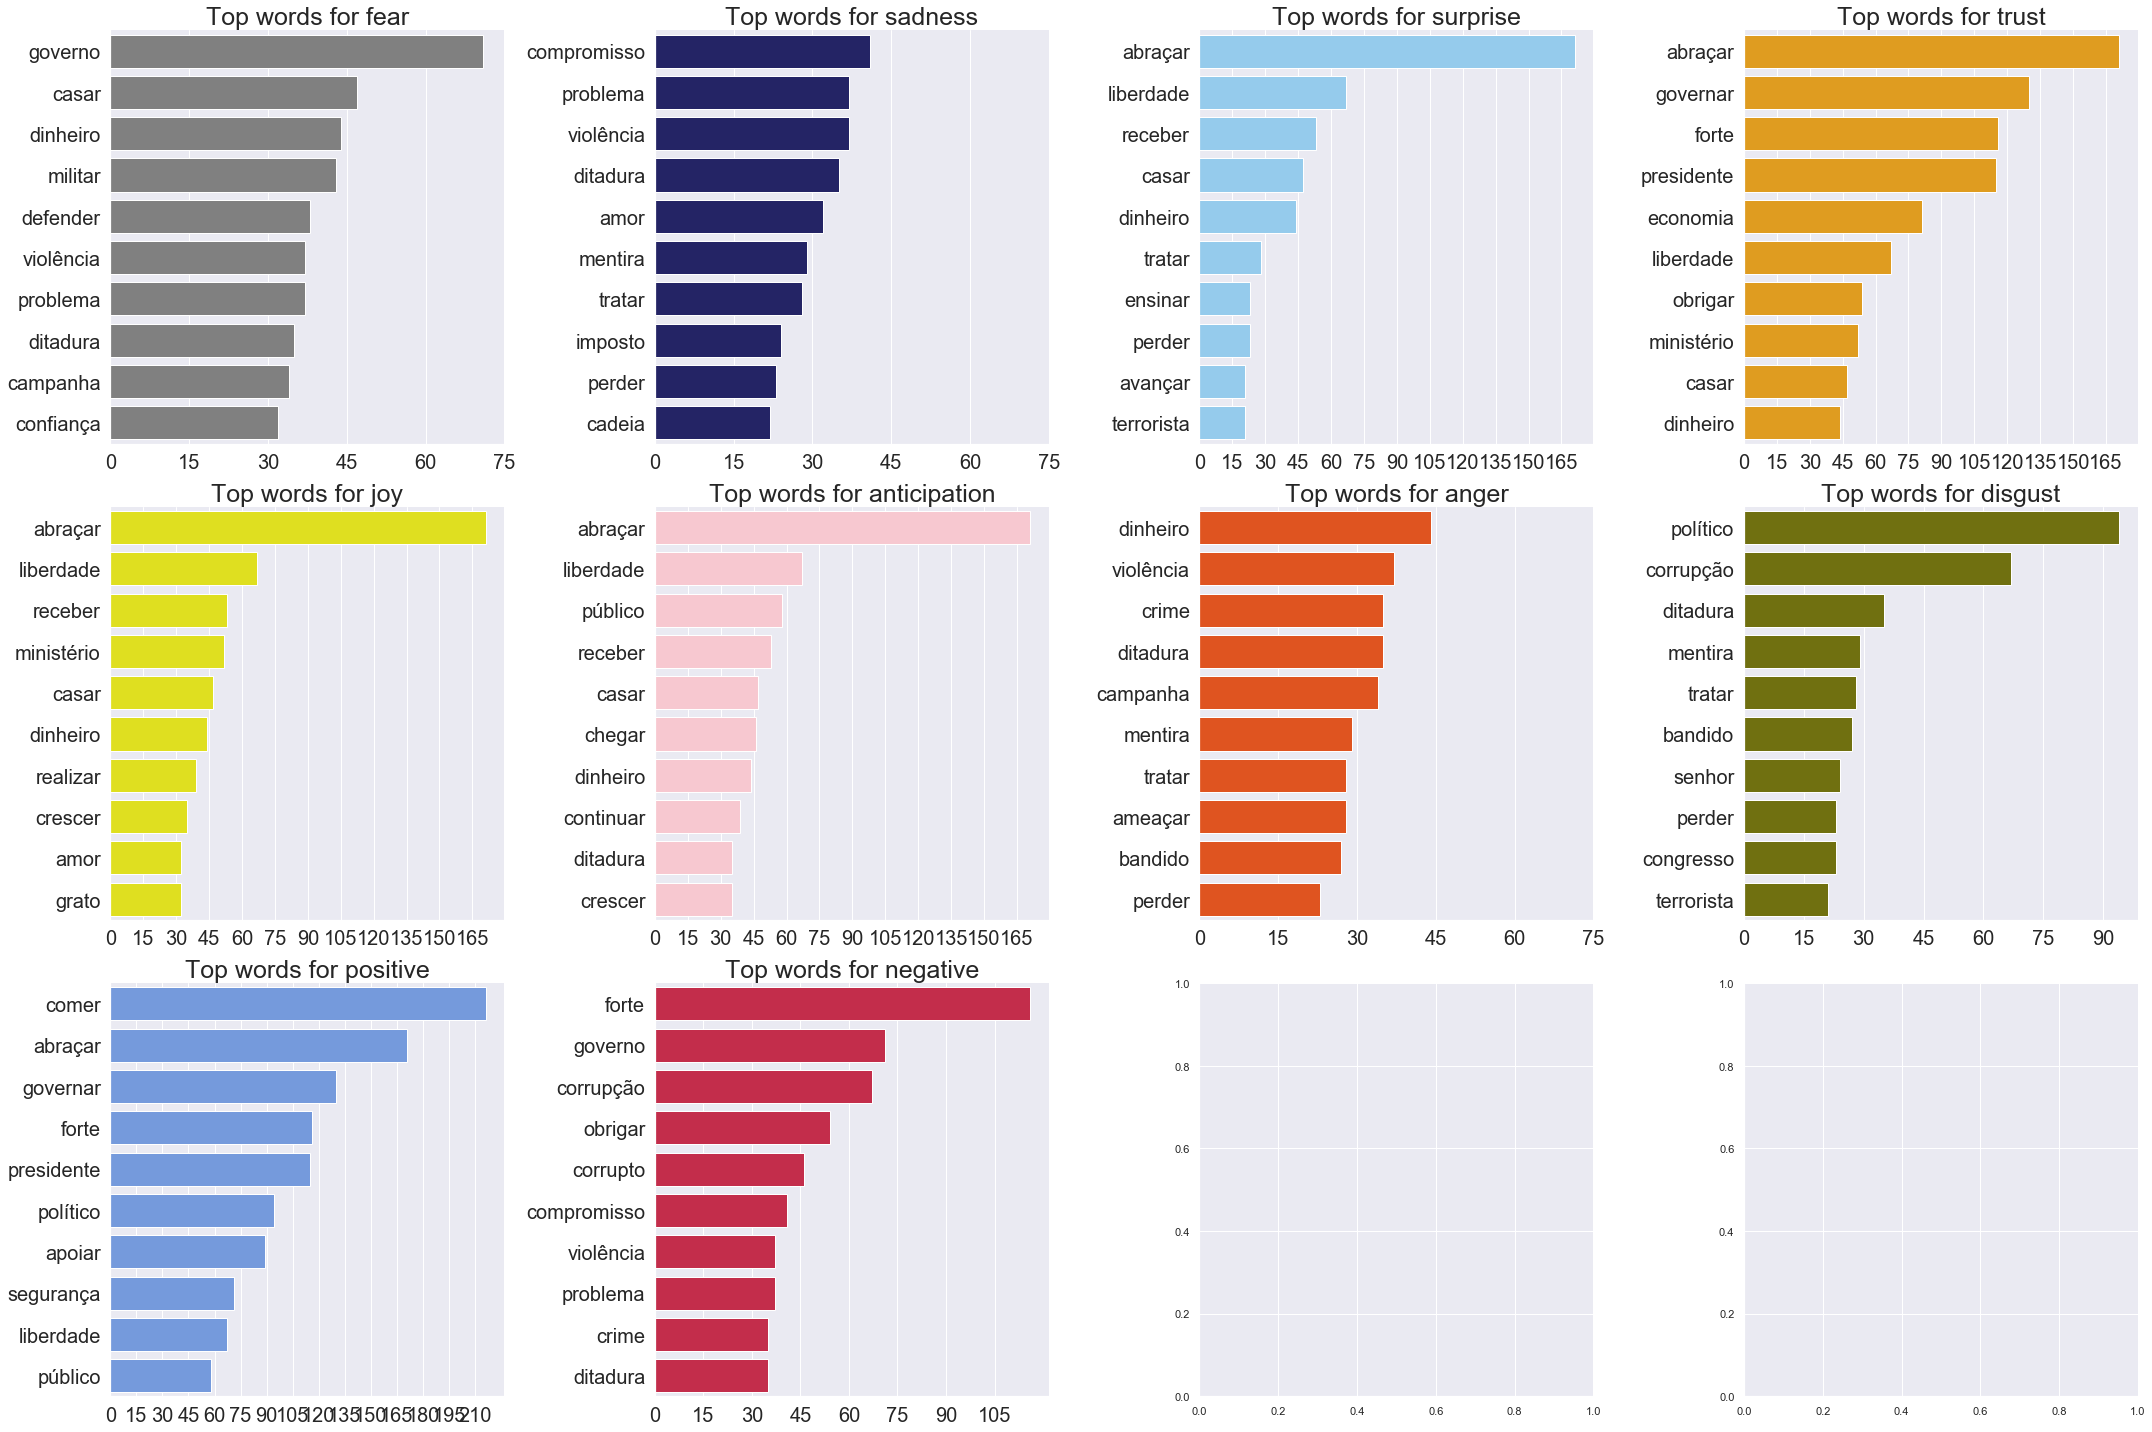

In [54]:
ROWS = 3
COLS = 4
cols_to_iterate = columns[1:]
colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive', 'cornflowerblue', 'crimson']
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(30,20))
words_which_appear = []
for row in range(ROWS):
    for col in range(COLS):
        if not cols_to_iterate:
            break
        a_column = cols_to_iterate.pop(0)
        a_color = colors.pop(0)
        a_df = pd.DataFrame(word_appearances_by_sentiment.sort_values(by=[a_column], ascending=False)[a_column][:10])
        words_which_appear.extend(a_df.index)
        a_df.columns = ['count']
        sns.barplot(a_df['count'], a_df.index,orient='h', color=a_color, ax=axes[row, col])
        axes[row, col].set_title('Top words for %s' % a_column, fontsize=25)
        if max(a_df['count']) > 90:
            axes[row, col].set_xticks(range(0,max(a_df['count']), 15))
        else:
            axes[row, col].set_xticks(range(0,80, 15))
        for tick in axes[row, col].xaxis.get_major_ticks():
            tick.label.set_fontsize(20) 
        for tick in axes[row, col].yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        axes[row, col].set_ylabel("")
        axes[row, col].set_xlabel("")

words_which_appear = Counter(words_which_appear)        
sns.despine()
plt.tight_layout()
plt.show();

In [55]:
word_appearances_by_sentiment.shape

(7571, 10)

In [56]:
def word_cloud(df, title):
    wd_list = df['clean_text']
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)


    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.title('Word Cloud for '+ title, fontsize=16)
    plt.imshow(wordcloud, interpolation="bilinear");

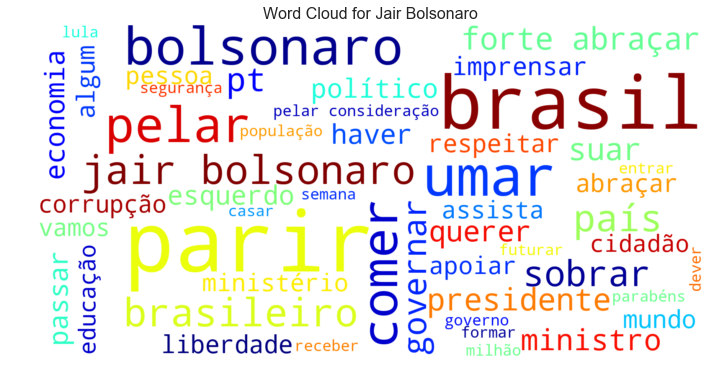

In [57]:
word_cloud(jb_tws, 'Jair Bolsonaro')

---

## Automatizing Cleaning & Analysis 

In [58]:
!ls

01_capturing_and_saving_raw_tweets.ipynb
02_capturing_tweets_on_a_dataset.ipynb
03_analyzing_tweets_spacy.ipynb
04_1_analyzing_tweets_V2.ipynb
BlogDoPim_tweets.csv
BolsonaroSP_tweets.csv
CarlosBolsonaro_tweets.csv
FlavioBolsonaro_tweets.csv
Haddad_Fernando_tweets.csv
LulaOficial_tweets.csv
Marcelo_Rovai_PP2_Project_Draft_5april19.docx
Marcelo_Rovai_PP2_Project_Draft_5april19.pdf
NRC-Sentiment-Emotion-Lexicons
Portuguese (Portugal, Brazil)-pt-NRC-VAD-Lexicon.txt
Tweets_General_Analysis.ipynb
gleisi_tweets.csv
jairbolsonaro_tweets.csv
papers
port_stop_words.rtf
port_stopwords.txt
raw_data
tweets_dataset
~$rcelo_Rovai_PP2_Project_Draft_5april19.docx


In [59]:
def create_dataset_sentiment(screen_name):
    ds_tws = pd.read_csv(screen_name+'_tweets.csv')
    ds_tws['clean_text'] = pre_clean_tweets(ds_tws['text'])
    ds_tws['clean_text'] = spacy_cleanup_text(ds_tws['clean_text'])
    ds_tws['anger'] = 0.0
    ds_tws['anticipation'] = 0.0
    ds_tws['disgust'] = 0.0
    ds_tws['fear'] = 0.0
    ds_tws['joy'] = 0.0
    ds_tws['negative'] = 0.0
    ds_tws['positive'] = 0.0
    ds_tws['sadness'] = 0.0
    ds_tws['surprise'] = 0.0
    ds_tws['trust'] = 0.0
    for index, _ in ds_tws.iterrows():
        txt = ds_tws.clean_text[index]    
        summary =  get_sentiments(txt)
        for key in summary.keys():
            ds_tws.at[index, key] = summary[key]
    return ds_tws

In [60]:
def plot_emotions(df):
    total_sentiments = pd.DataFrame(df.sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']].sort_values(ascending=False))
    colors = ['pink', 'midnightblue', 'orange', 'yellow', 'grey', 'lightskyblue', 'orangered',  'olive']
    total_sentiments.columns = ['value']

    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x=total_sentiments.index, y='value', data=total_sentiments, palette=sns.color_palette(colors))
    plt.ylabel("")
    plt.xlabel('Emotion', fontsize=20)
    plt.title('Distribution of values from NRC emotions', fontsize=25)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    sns.despine()
    plt.plot();
    return total_sentiments

In [61]:
def plot_polarity(df):
    total_sentiment = pd.DataFrame(df.sum()[['positive', 'negative']])
    total_sentiment.columns = ['value']

    fig, ax = plt.subplots(figsize=(15,7))
    ax = sns.barplot(x=total_sentiment.index, y='value', data=total_sentiment, palette=sns.color_palette(['cornflowerblue', 'crimson']))
    plt.ylabel("")
    plt.xlabel('Sentiment', fontsize=20)
    plt.title('Distribution of values from NRC sentiments (Polarity)', fontsize=25)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - .3

        # we change the bar width
        patch.set_width(.3)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
    sns.despine()
    plt.plot();
    return total_sentiment

In [62]:
def get_words_emotions(df):
    columns = ['word','fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust', 'positive', 'negative']
    word_appearances_by_sentiment = pd.DataFrame(columns=columns)
    for index, _ in df.iterrows():
        txt = df.clean_text[index]   
        doc = nlp(txt)
        tokens = [token for token in doc]
        list_of_strings  = [i.text for i in tokens]
        annotation = lexicon.annotate_doc(list_of_strings)
        for token, a_set in zip(list_of_strings, annotation):
            row = [token] + [x in a_set for x in columns[1:]]
            appending_df = pd.DataFrame([row], columns=columns)
            word_appearances_by_sentiment = word_appearances_by_sentiment.append(appending_df)

    word_appearances_by_sentiment = word_appearances_by_sentiment.groupby("word").agg(
        {'anger': np.sum,
         'anticipation': np.sum,
         'disgust': np.sum,
         'fear': np.sum,
         'joy': np.sum,
         'negative': np.sum,
         'positive': np.sum,
         'sadness': np.sum,
         'surprise': np.sum,
         'trust': np.sum}
    )
    plot_top_words_by_sentiment(word_appearances_by_sentiment)
    return word_appearances_by_sentiment

In [63]:
def plot_top_words_by_sentiment(df):
    ROWS = 3
    COLS = 4
    cols_to_iterate = columns[1:]
    colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive', 'cornflowerblue', 'crimson']
    fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(30,20))
    words_which_appear = []
    for row in range(ROWS):
        for col in range(COLS):
            if not cols_to_iterate:
                break
            a_column = cols_to_iterate.pop(0)
            a_color = colors.pop(0)
            a_df = pd.DataFrame(df.sort_values(by=[a_column], ascending=False)[a_column][:10])
            words_which_appear.extend(a_df.index)
            a_df.columns = ['count']
            sns.barplot(a_df['count'], a_df.index,orient='h', color=a_color, ax=axes[row, col])
            axes[row, col].set_title('Top words for %s' % a_column, fontsize=25)
            if max(a_df['count']) > 90:
                axes[row, col].set_xticks(range(0,max(a_df['count']), 15))
            else:
                axes[row, col].set_xticks(range(0,80, 15))
            for tick in axes[row, col].xaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
            for tick in axes[row, col].yaxis.get_major_ticks():
                tick.label.set_fontsize(20)
            axes[row, col].set_ylabel("")
            axes[row, col].set_xlabel("")

    words_which_appear = Counter(words_which_appear)        
    sns.despine()
    plt.tight_layout()
    plt.show();

In [64]:
screen_name = 'CarlosBolsonaro'

In [65]:
cb_twt = create_dataset_sentiment(screen_name)
cb_twt.head(2)

,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,2019-03-31 12:46:40,93,386,A população agradece! https://t.co/1m0PZ3GXvk,população agradecer,0.0,0.000000,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000
1,2019-03-30 14:29:31,1654,6375,"Mais detalhes sobre a Nova Previdência, por @V...",detalhe sobrar previdência,0.0,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333


,value
trust,234.653
fear,149.109
anticipation,144.186
anger,125.118
sadness,115.578
disgust,104.618
joy,103.81
surprise,83.6823


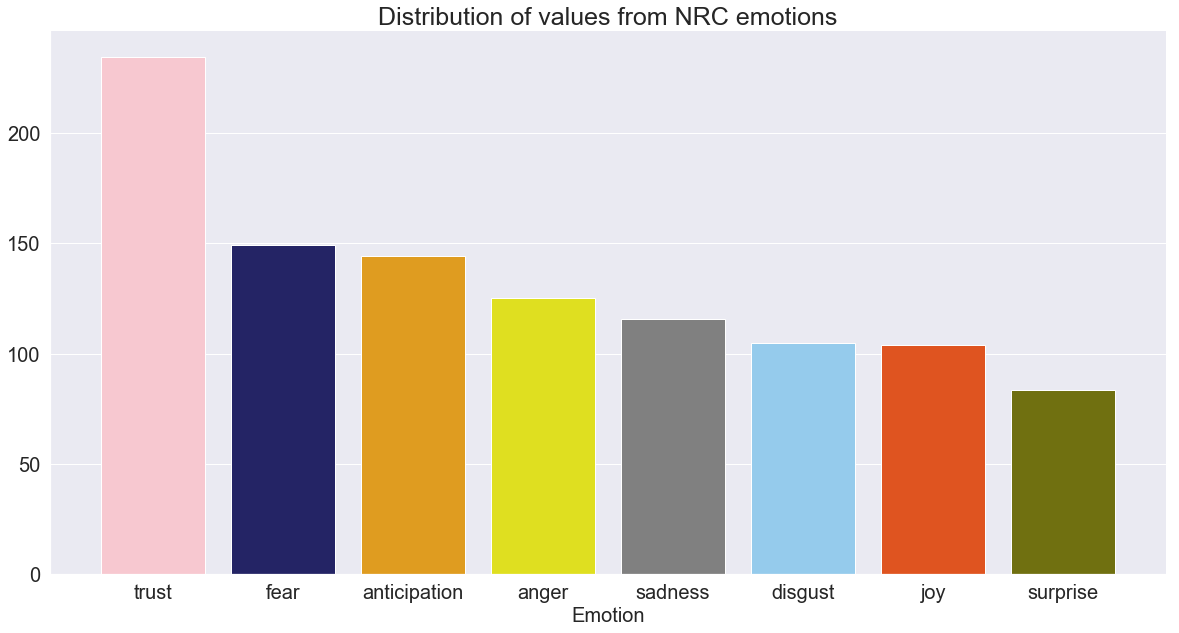

In [66]:
plot_emotions(cb_twt)

,value
positive,357.324
negative,267.995


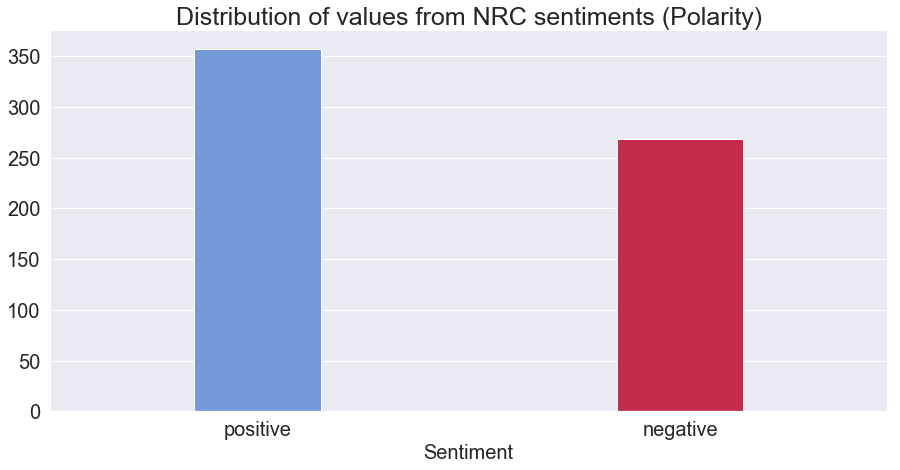

In [67]:
plot_polarity(cb_twt)

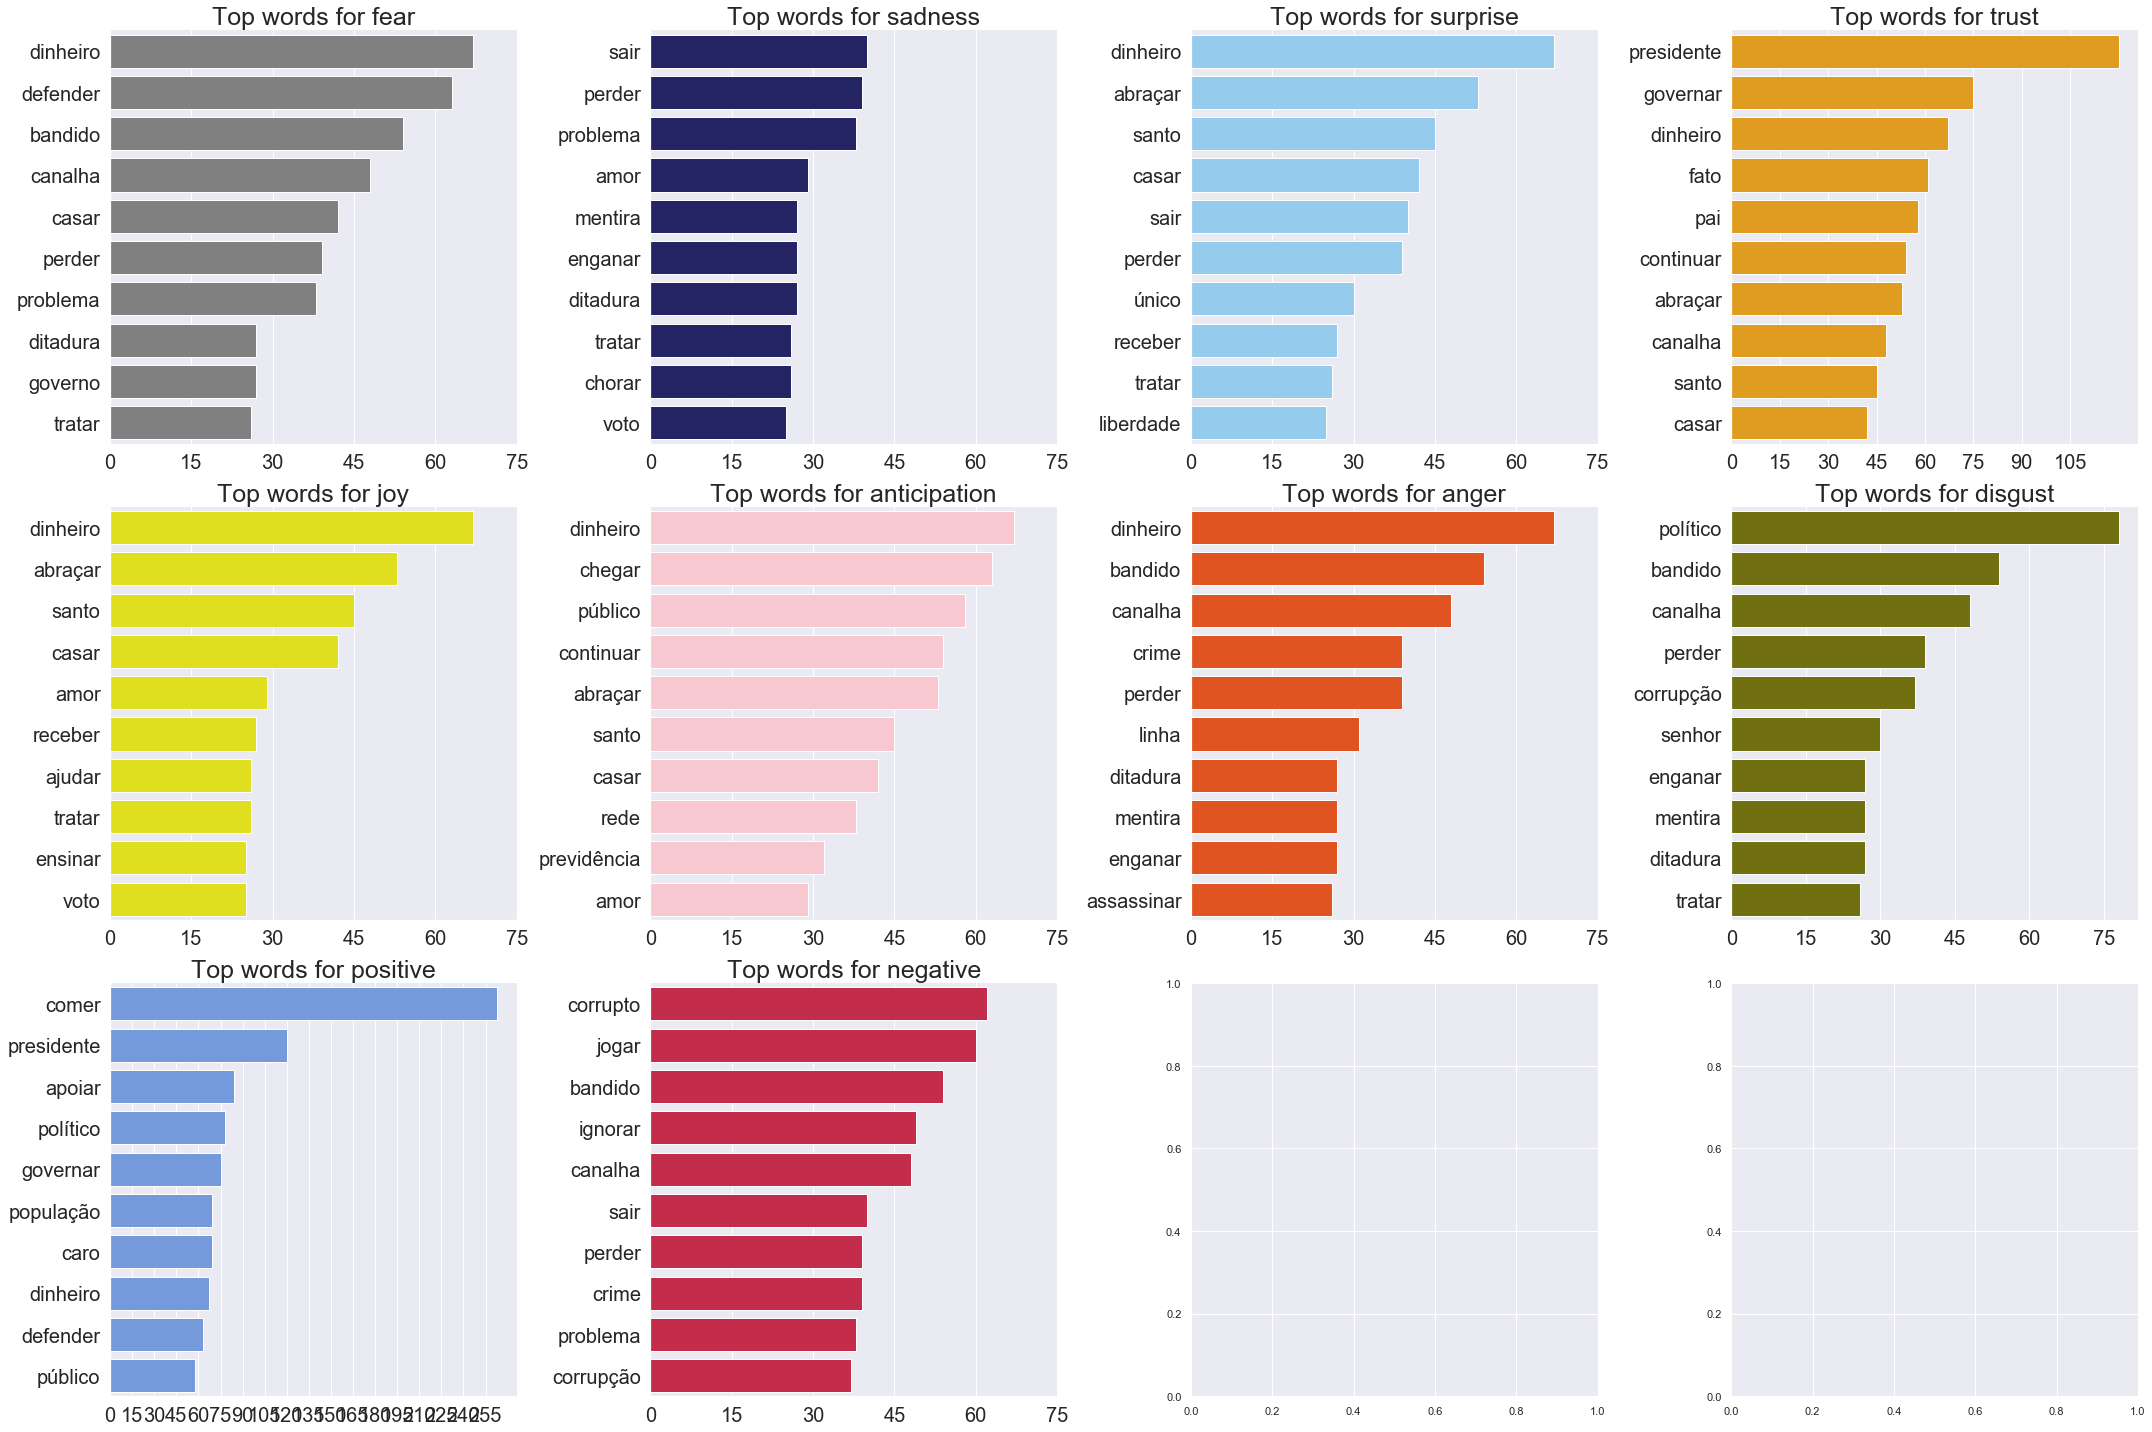

In [68]:
word_by_emotion = get_words_emotions(cb_twt)

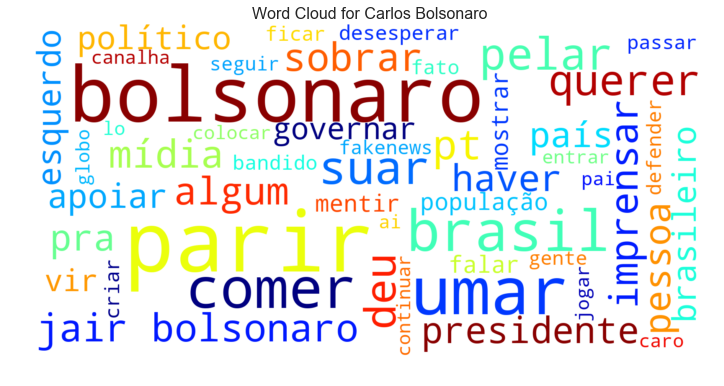

In [69]:
word_cloud(cb_twt, 'Carlos Bolsonaro')

---

In [70]:
def tweet_analysis(screen_name, word_sent = False):
    twt = create_dataset_sentiment(screen_name)
    plot_emotions(twt)
    plot_polarity(twt)
    if word_sent:
        word_by_emotion = get_words_emotions(twt)
    word_cloud(twt, screen_name)
    return twt

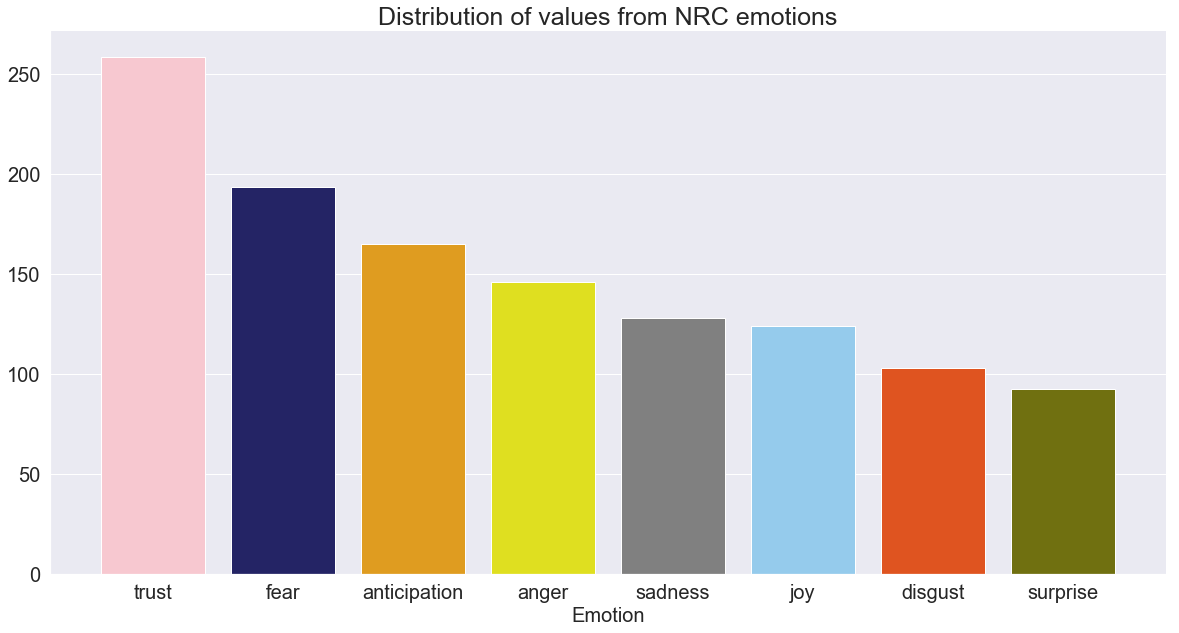

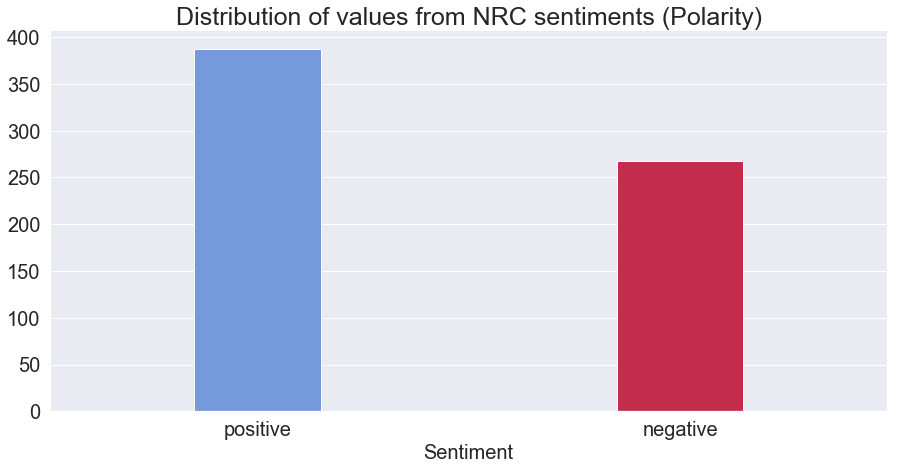

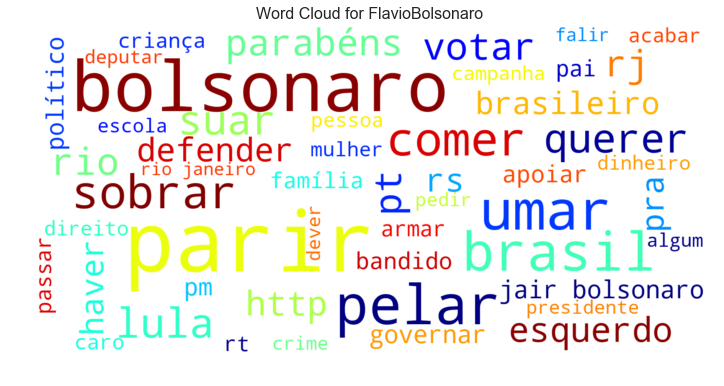

In [71]:
screen_name = 'FlavioBolsonaro'
fb_twt = tweet_analysis(screen_name, False)

---

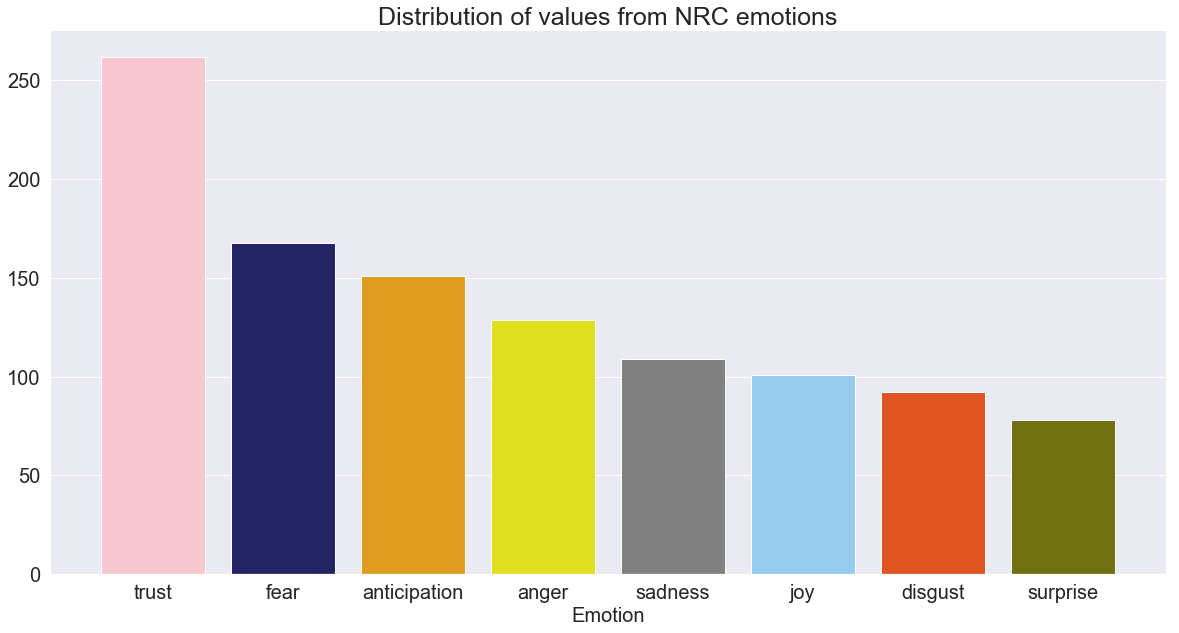

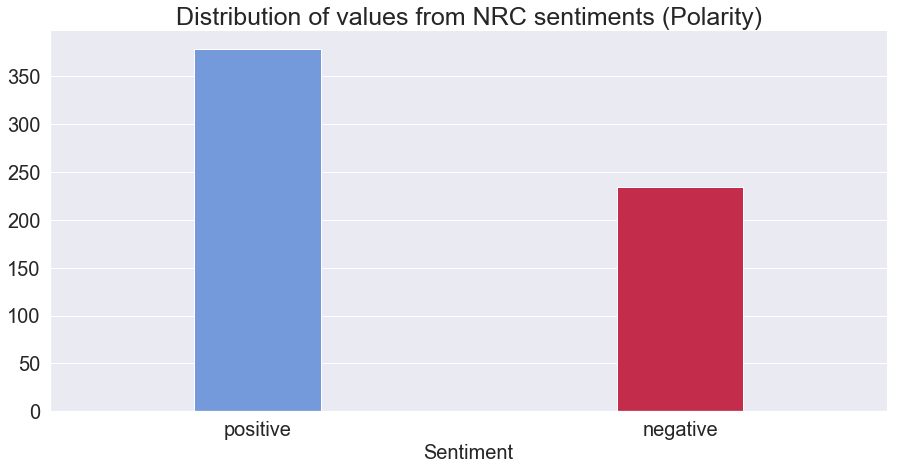

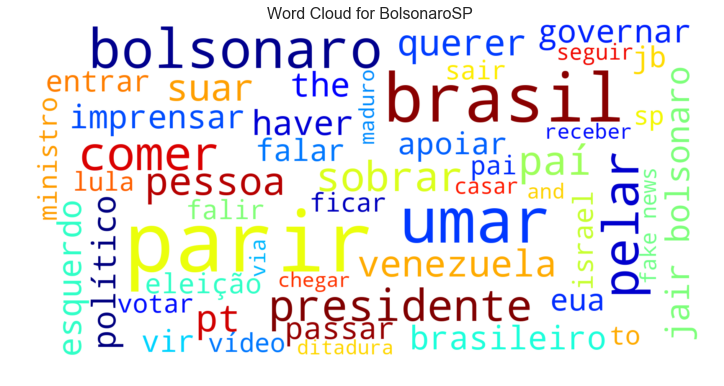

In [72]:
screen_name = 'BolsonaroSP'
eb_twt = tweet_analysis(screen_name, False)

---

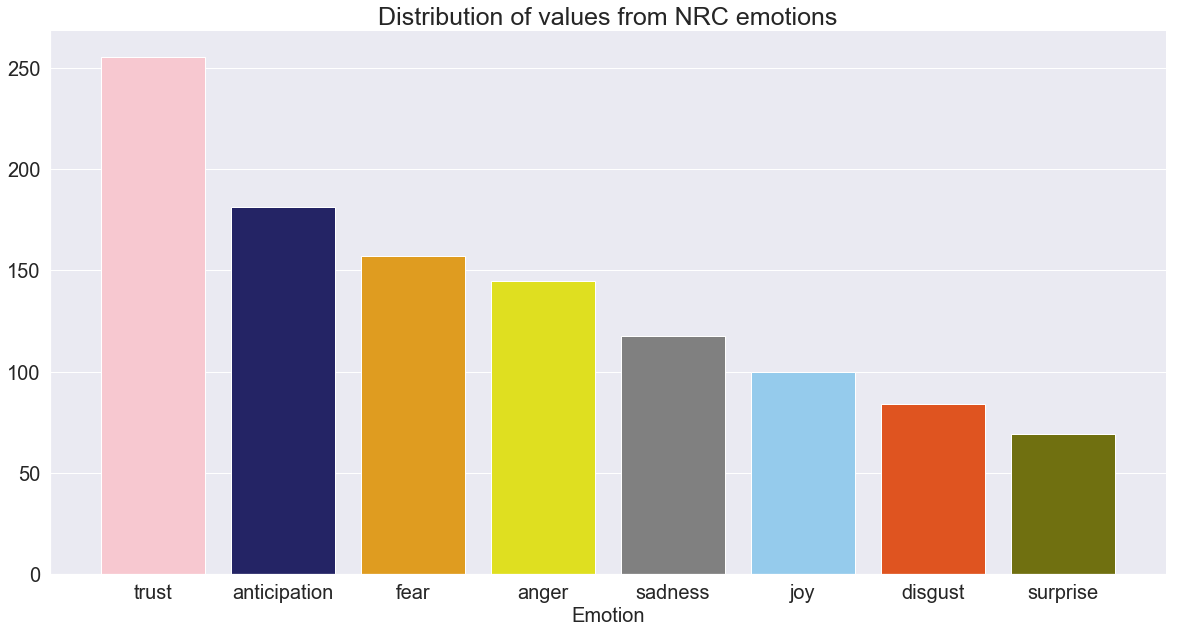

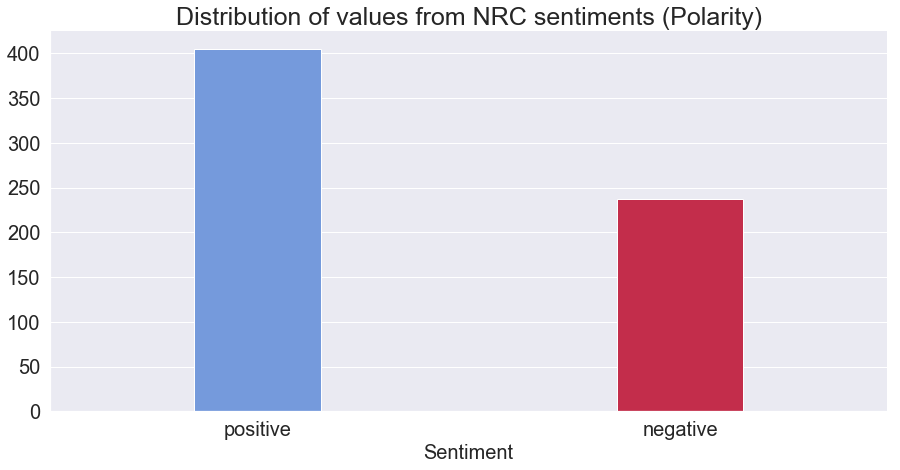

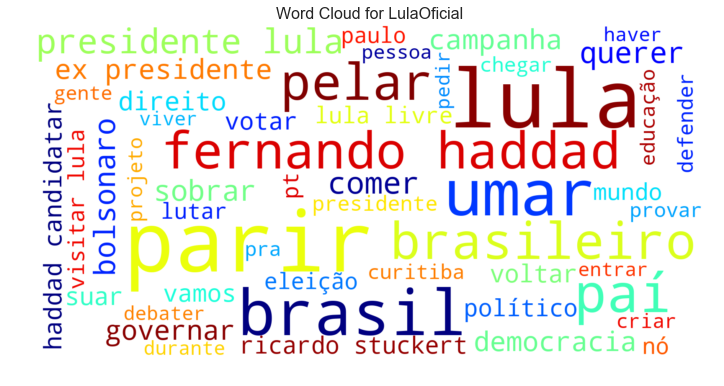

In [73]:
screen_name = 'LulaOficial'
ls_twt = tweet_analysis(screen_name, False)

---

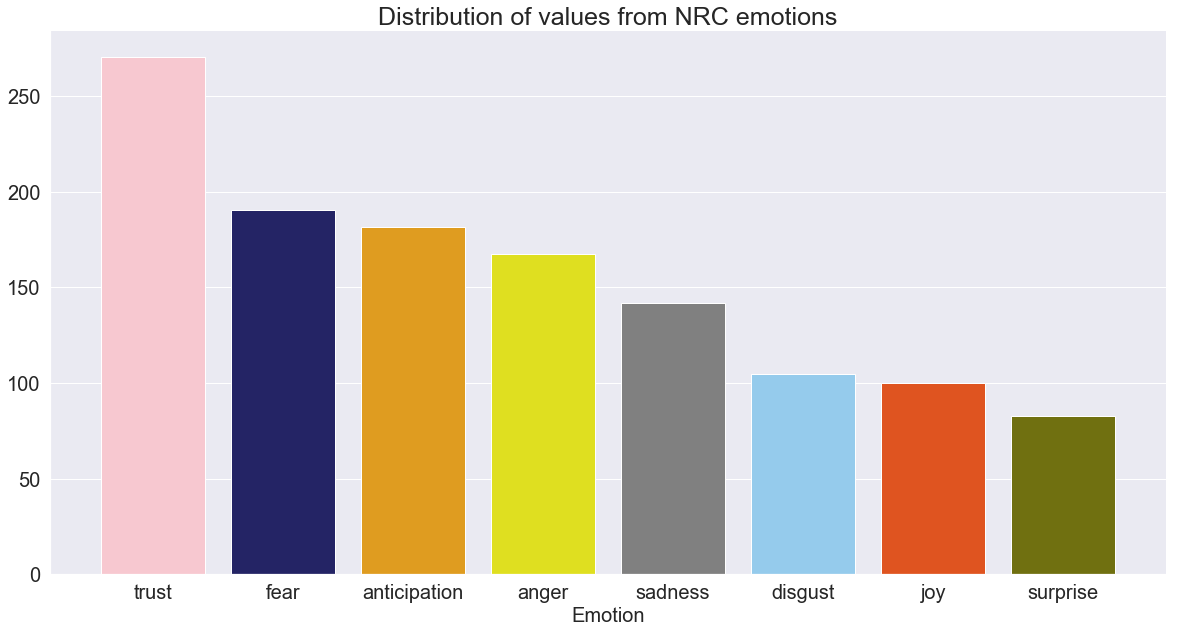

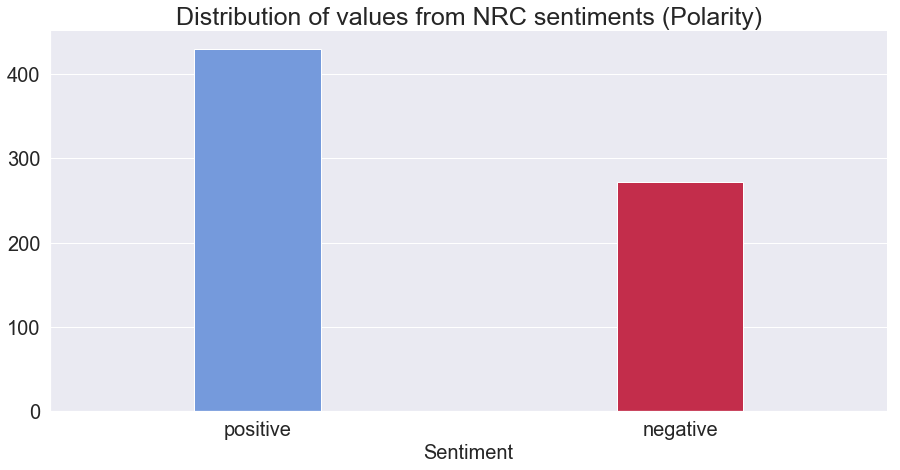

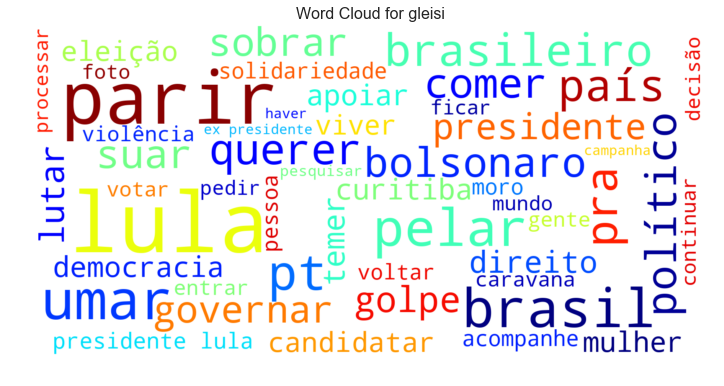

In [74]:
screen_name = 'gleisi'
gh_twt = tweet_analysis(screen_name, False)

---

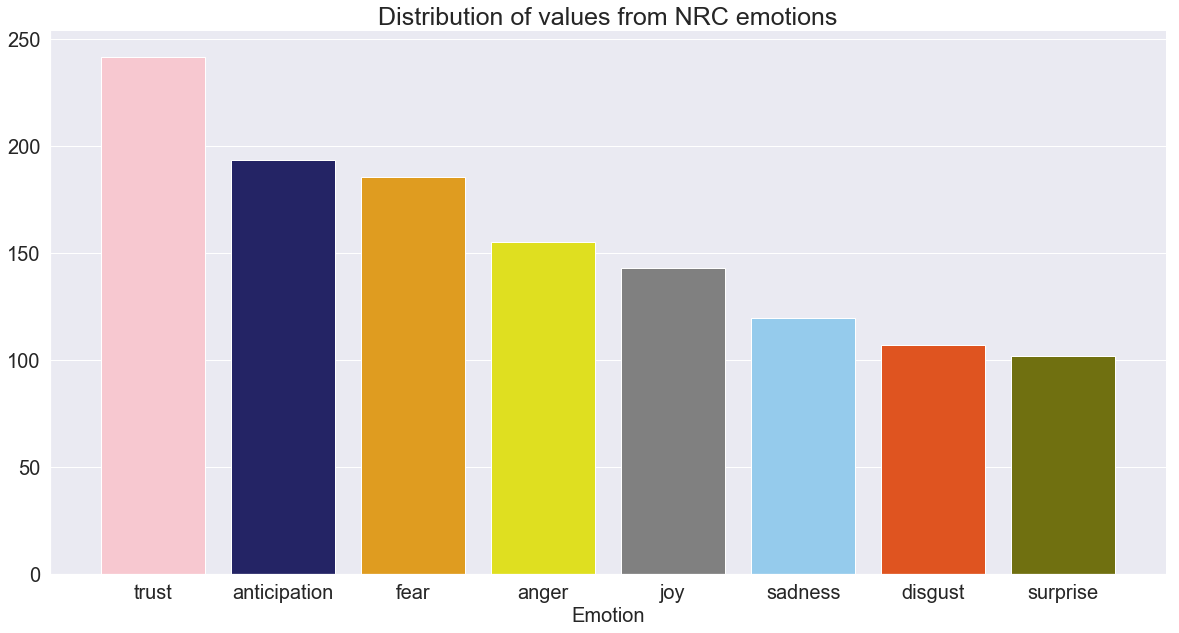

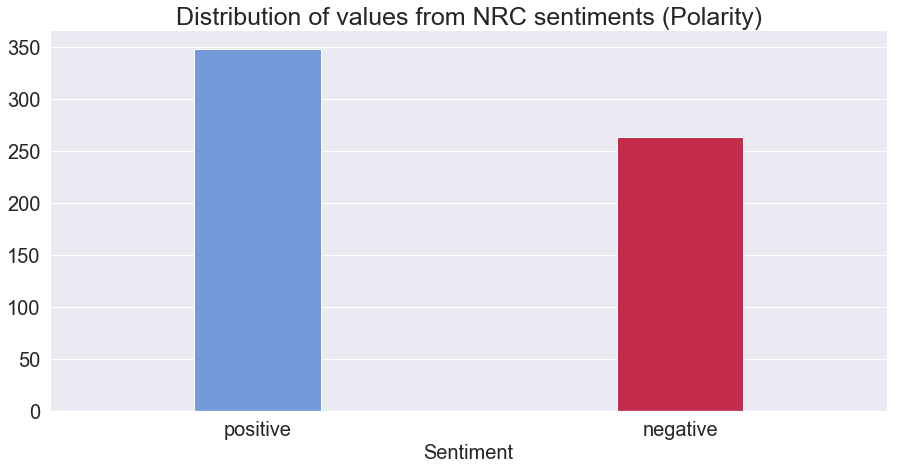

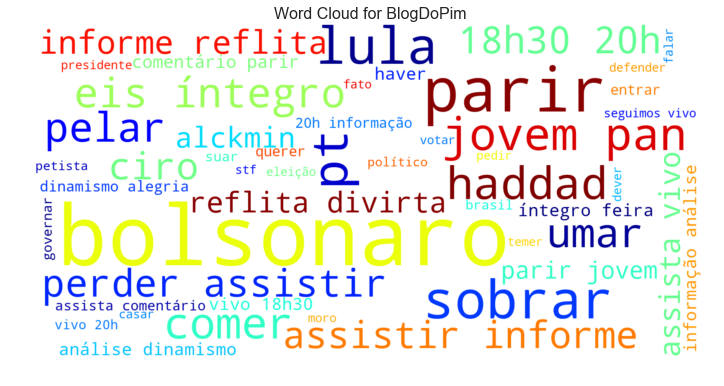

In [75]:
screen_name = 'BlogDoPim'
fm_twt = tweet_analysis(screen_name, False)

---

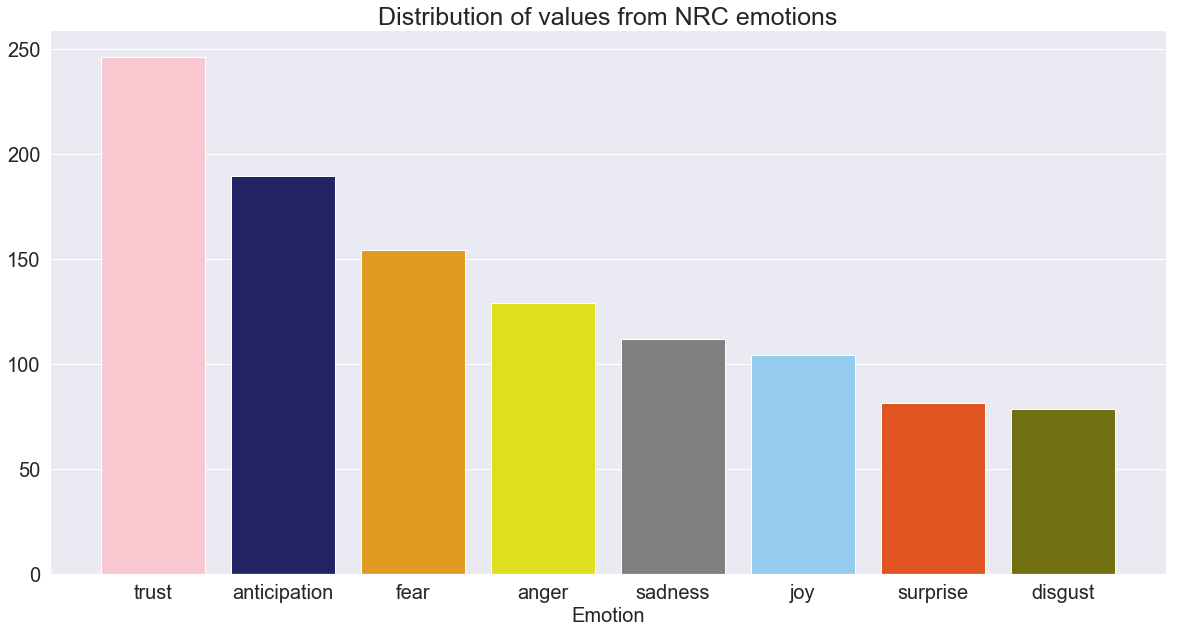

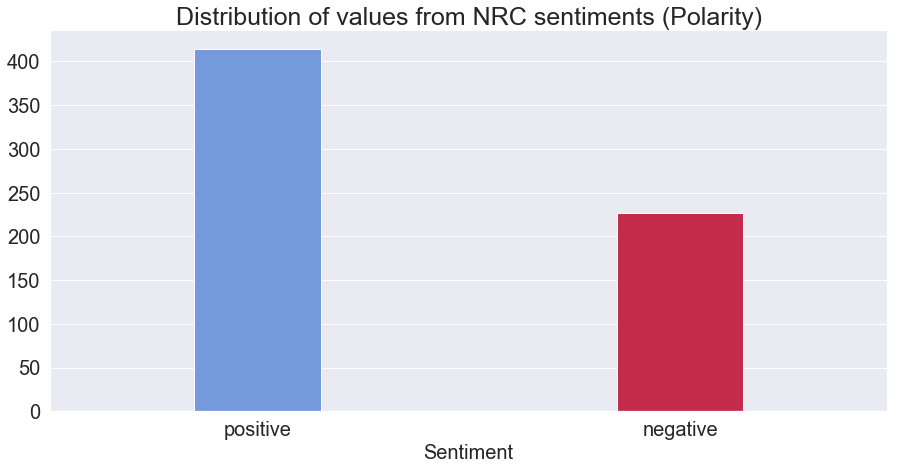

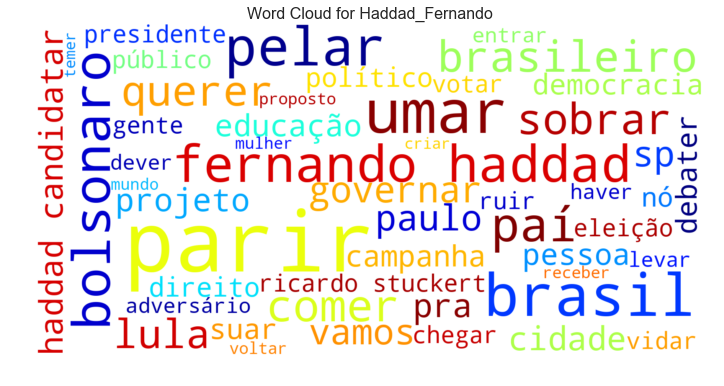

In [76]:
screen_name = 'Haddad_Fernando'
fh_twt = tweet_analysis(screen_name, False)

---

---

---


## Saving enhanced datasets

In [80]:
jb_tws.head()

,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,screen_name
0,2019-03-31 18:24:50,2985,17307,Reconhecendo os vínculos históricos de Jerusal...,reconhecendo vínculo histórico jerusalém ident...,0.0,0.000000,0.045455,0.0,0.0,0.000000,0.181818,0.000000,0.00,0.045455,jairbolsonaro
1,2019-03-31 12:19:57,6288,34952,Chegamos há pouco em Israel. Fomos recepcionad...,chegamos haver israel recepcionados pelar prim...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.083333,0.000000,0.00,0.166667,jairbolsonaro
2,2019-03-31 10:22:14,4035,30343,Ao renovar as concessões de trechos rodoviário...,renovar concessão trecho rodoviário revisar co...,0.0,0.055556,0.000000,0.0,0.0,0.055556,0.166667,0.055556,0.00,0.111111,jairbolsonaro
3,2019-03-31 10:19:02,6327,41684,Após revelação do @MInfraestrutura de pedidos ...,revelação pedir pronto 8.000 radar eletrônicos...,0.0,0.050000,0.000000,0.0,0.0,0.000000,0.050000,0.000000,0.05,0.050000,jairbolsonaro
4,2019-03-30 20:25:30,5619,26156,- Ministro da Infraestrutura @tarcisiogdf (cap...,ministro infraestrutura capitão exército espec...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.333333,0.000000,0.00,0.166667,jairbolsonaro


In [79]:
jb_tws["screen_name"] = 'jairbolsonaro'

In [86]:
screen_name = "jairbolsonaro"
jb_tws.to_csv("./tweets_dataset/"+screen_name+"_emot_tweets.csv")

In [87]:
screen_name = "CarlosBolsonaro"
cb_twt["screen_name"] = screen_name
cb_twt.to_csv("./tweets_dataset/"+screen_name+"_emot_tweets.csv")

In [88]:
screen_name = "BolsonaroSP"
eb_twt["screen_name"] = screen_name
eb_twt.to_csv("./tweets_dataset/"+screen_name+"_emot_tweets.csv")

In [89]:
screen_name = "FlavioBolsonaro"
fb_twt["screen_name"] = screen_name
fb_twt.to_csv("./tweets_dataset/"+screen_name+"_emot_tweets.csv")

In [90]:
screen_name = "LulaOficial"
ls_twt["screen_name"] = screen_name
ls_twt.to_csv("./tweets_dataset/"+screen_name+"_emot_tweets.csv")

In [91]:
screen_name = "gleisi"
gh_twt["screen_name"] = screen_name
gh_twt.to_csv("./tweets_dataset/"+screen_name+"_emot_tweets.csv")

In [92]:
screen_name = "BlogDoPim"
fm_twt["screen_name"] = screen_name
fm_twt.to_csv("./tweets_dataset/"+screen_name+"_emot_tweets.csv")

In [93]:
screen_name = "Haddad_Fernando"
fh_twt["screen_name"] = screen_name
fh_twt.to_csv("./tweets_dataset/"+screen_name+"_emot_tweets.csv")

---


## Generating a single dataset

In [94]:
df = jb_tws.copy()

In [97]:
df = df.append(cb_twt)

In [98]:
df = df.append(eb_twt)
df = df.append(fb_twt)
df = df.append(ls_twt)
df = df.append(gh_twt)
df = df.append(fm_twt)
df = df.append(fh_twt)

In [99]:
df.shape

(25650, 16)

In [101]:
df.screen_name.value_counts()

gleisi             3241
LulaOficial        3237
BolsonaroSP        3221
BlogDoPim          3219
Haddad_Fernando    3215
jairbolsonaro      3185
FlavioBolsonaro    3182
CarlosBolsonaro    3150
Name: screen_name, dtype: int64

In [102]:
df.to_csv("./tweets_dataset/df_emot_tweets.csv")

---


## Appendix - Tests 

In [103]:
txt = 'feliz triste dinheiro lindo prisão feio'
show_annotation(txt)

feliz  ==>  {'joy', 'anticipation', 'trust', 'positive'}
triste  ==>  {'fear', 'sadness', 'negative'}
dinheiro  ==>  {'anger', 'joy', 'surprise', 'trust', 'fear', 'anticipation', 'positive'}
lindo  
prisão  ==>  {'anger', 'fear', 'sadness', 'disgust', 'negative'}
feio  ==>  {'negative', 'disgust'}


In [104]:
ls_twt.head()

,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,screen_name
0,2019-04-03 20:13:21,77,307,"As 50 fotografias históricas de Lula, doadas p...",50 fotografia histórico lula doar algum renoma...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,LulaOficial
1,2019-04-03 13:24:33,2802,14555,Lula foi o 1º presidente brasileiro a visitar ...,lula 1º presidente brasileiro visitar israel v...,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.272727,0.000000,0.045455,0.227273,LulaOficial
2,2019-04-03 12:51:57,290,1514,"As 50 fotografias históricas de Lula, doadas p...",50 fotografia histórico lula doar algum renoma...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,LulaOficial
3,2019-04-03 01:50:30,239,0,RT @ptbrasil: Vai ter resistência no sul do Br...,resistência sul brasil programe-se parir carav...,0.125000,0.125000,0.000000,0.000000,0.125000,0.125000,0.250000,0.000000,0.125000,0.125000,LulaOficial
4,2019-04-02 21:46:50,1036,4934,"Boa sorte! Porque, infelizmente para o povo, g...",sortir infelizmente parir gerar emprego lula 2...,0.000000,0.000000,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,LulaOficial


In [105]:
ls_twt.text[1]

'Lula foi o 1º presidente brasileiro a visitar Israel. Mas também visitou a Palestina, não ofendeu povos e religiões, defendeu a paz e a solução pacífica de dois estados, respeitando a tradição diplomática brasileira. E o Brasil ganhou com mais respeito e comércio #timeLula https://t.co/2uonprCZfV'

In [106]:
ls_twt.clean_text[1]

'lula 1º presidente brasileiro visitar israel visitar palestina ofender religião defender paz solução pacífico respeitar tradição diplomático brasileiro brasil ganhar respeitar comércio'

In [107]:
show_annotation(ls_twt.clean_text[1])

lula  
1º  
presidente  ==>  {'positive', 'trust'}
brasileiro  
visitar  
israel  
visitar  
palestina  
ofender  ==>  {'anger', 'negative', 'disgust'}
religião  ==>  {'trust'}
defender  ==>  {'positive', 'fear'}
paz  
solução  ==>  {'positive'}
pacífico  ==>  {'joy', 'surprise', 'trust', 'anticipation', 'positive'}
respeitar  
tradição  
diplomático  ==>  {'positive', 'trust'}
brasileiro  
brasil  
ganhar  ==>  {'positive'}
respeitar  
comércio  ==>  {'trust'}


In [108]:
get_sentiments(ls_twt.clean_text[1])

{'anger': 0.045454545454545456,
 'joy': 0.045454545454545456,
 'surprise': 0.045454545454545456,
 'fear': 0.045454545454545456,
 'sadness': 0.0,
 'positive': 0.2727272727272727,
 'trust': 0.22727272727272727,
 'disgust': 0.045454545454545456,
 'anticipation': 0.045454545454545456,
 'negative': 0.045454545454545456}

In [111]:
txt1 = "eu gosto de meu gato Romeu. Ele é bonito"
docc = nlp(txt1)
displacy.render(docc, style='dep', jupyter=True, options={'distance': 90})
show_annotation(txt1)
get_sentiments(txt1)

eu  
gosto  ==>  {'positive', 'joy', 'trust'}
de  
meu  
gato  
Romeu.  
Ele  
é  
bonito  


{'anger': 0.0,
 'joy': 0.1111111111111111,
 'surprise': 0.0,
 'fear': 0.0,
 'sadness': 0.0,
 'positive': 0.1111111111111111,
 'trust': 0.1111111111111111,
 'disgust': 0.0,
 'anticipation': 0.0,
 'negative': 0.0}

$Score_{A V G}=\frac{1}{m} \sum_{i=1}^{m} Emotion_{i}$